In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

import joblib

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Wczytanie i wstępna analiza danych

In [2]:
data_path = Path('../archive/diabetes.csv')
df = pd.read_csv(data_path)

print(f"Kształt danych: {df.shape}")
print(f"\nPierwsze 5 wierszy:")
df.head()

Kształt danych: (768, 9)

Pierwsze 5 wierszy:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print("Informacje o kolumnach:")
df.info()

print("\nStatystyki opisowe:")
df.describe()

Informacje o kolumnach:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Statystyki opisowe:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
print("Braki danych:")
print(df.isnull().sum())

zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\nWartości 0:")
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    zero_pct = 100 * zero_count / len(df)
    print(f"{col:20s}: {zero_count:3d} ({zero_pct:.1f}%)")

Braki danych:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Wartości 0:
Glucose             :   5 (0.7%)
BloodPressure       :  35 (4.6%)
SkinThickness       : 227 (29.6%)
Insulin             : 374 (48.7%)
BMI                 :  11 (1.4%)


Rozkład klasy docelowej:
Outcome
0    500
1    268
Name: count, dtype: int64

Proporcje:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


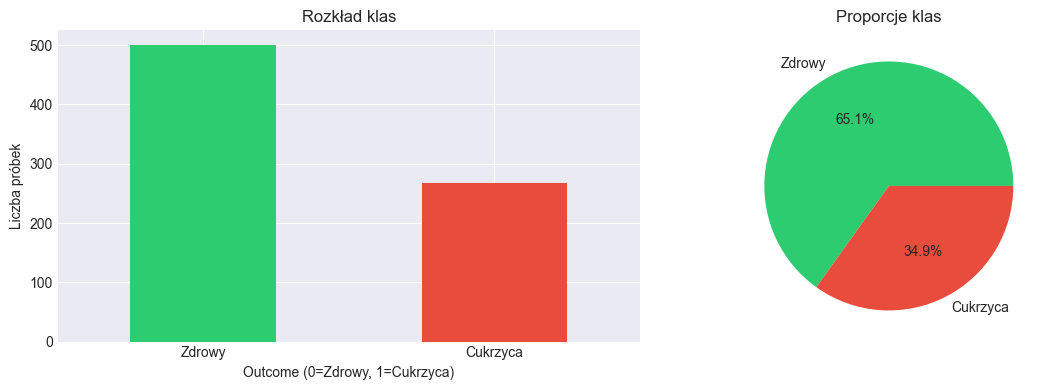

In [5]:
print("Rozkład klasy docelowej:")
print(df['Outcome'].value_counts())
print("\nProporcje:")
print(df['Outcome'].value_counts(normalize=True))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df['Outcome'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Rozkład klas')
ax[0].set_xlabel('Outcome (0=Zdrowy, 1=Cukrzyca)')
ax[0].set_ylabel('Liczba próbek')
ax[0].set_xticklabels(['Zdrowy', 'Cukrzyca'], rotation=0)

df['Outcome'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                   labels=['Zdrowy', 'Cukrzyca'],
                                   colors=['#2ecc71', '#e74c3c'])
ax[1].set_title('Proporcje klas')
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

## 2. Eksploracyjna analiza danych

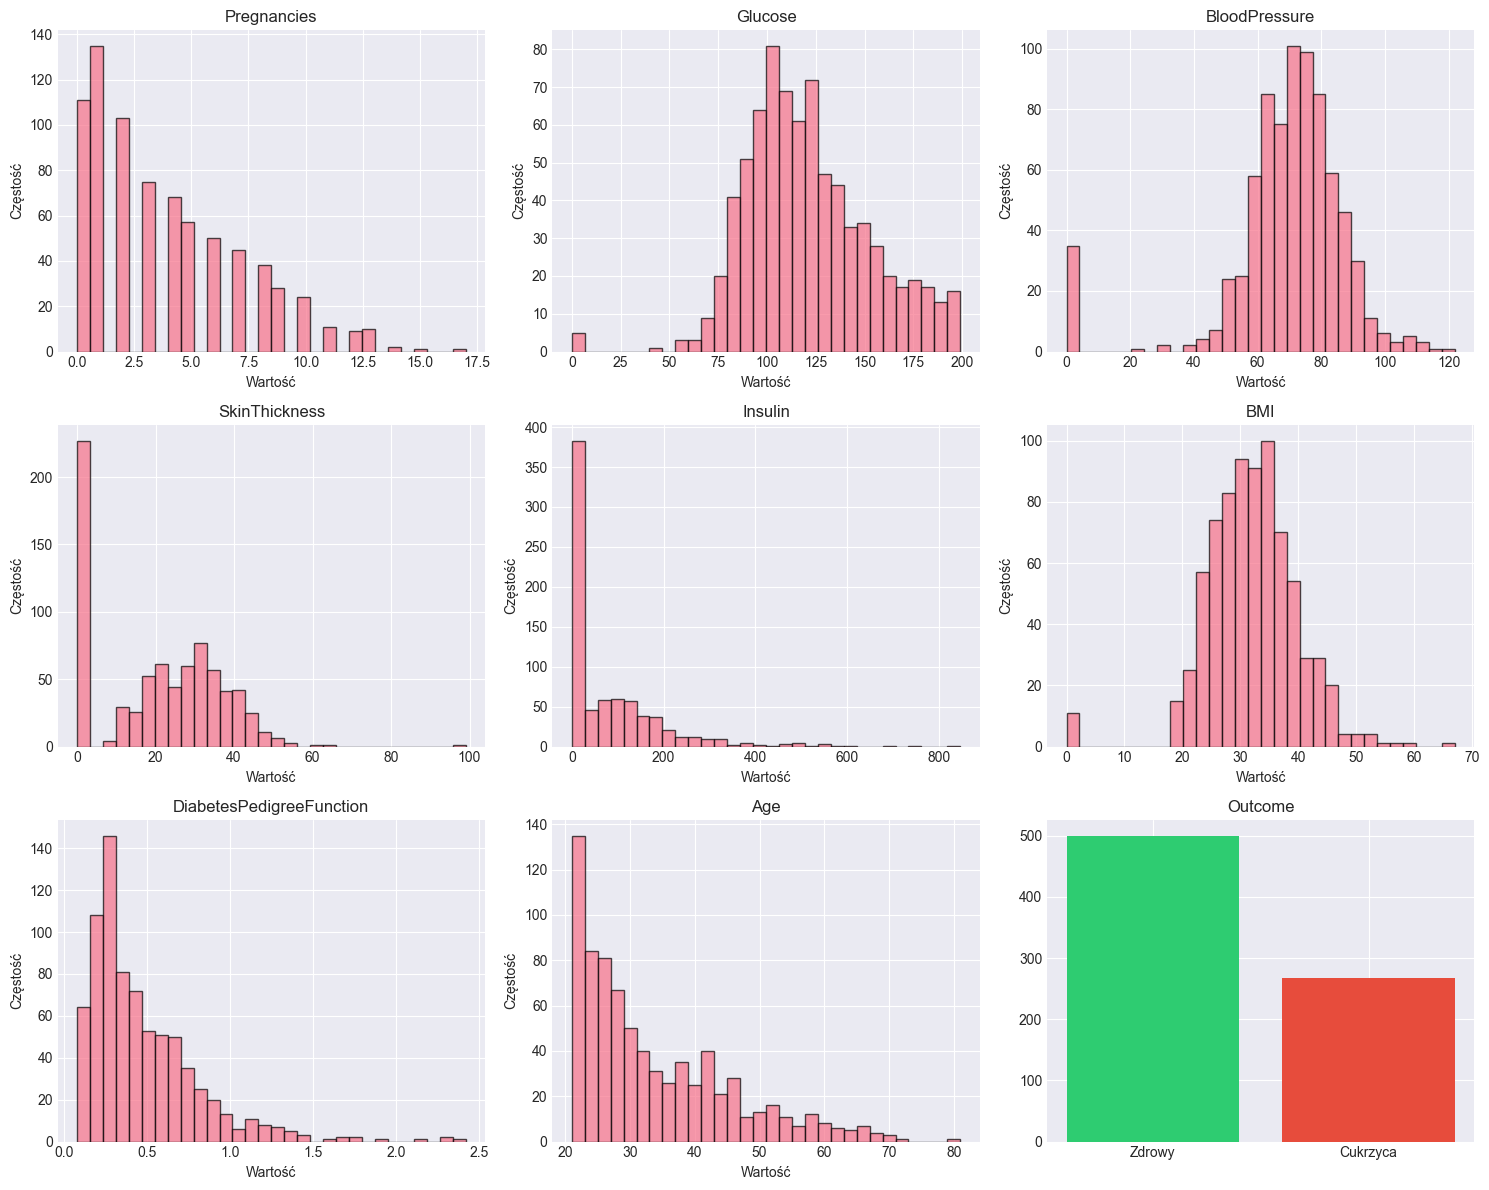

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    if col != 'Outcome':
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}')
        axes[idx].set_xlabel('Wartość')
        axes[idx].set_ylabel('Częstość')
    else:
        axes[idx].bar([0, 1], df[col].value_counts().sort_index(), color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title('Outcome')
        axes[idx].set_xticks([0, 1])
        axes[idx].set_xticklabels(['Zdrowy', 'Cukrzyca'])

plt.tight_layout()
plt.show()

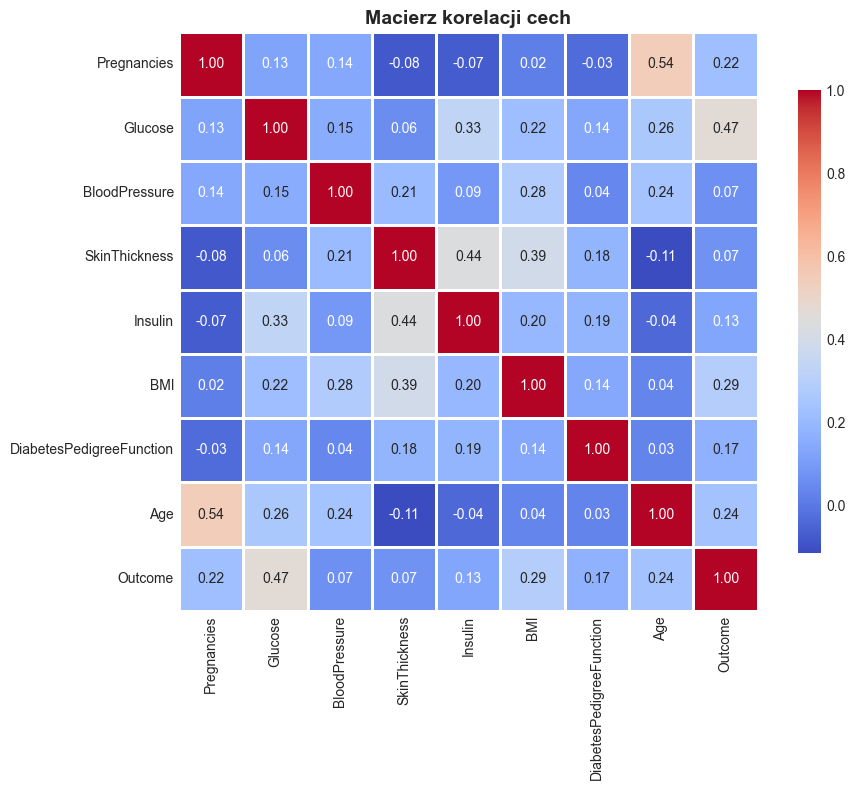

Korelacje z klasą docelową:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [7]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Macierz korelacji cech', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Korelacje z klasą docelową:")
print(corr_matrix['Outcome'].sort_values(ascending=False))

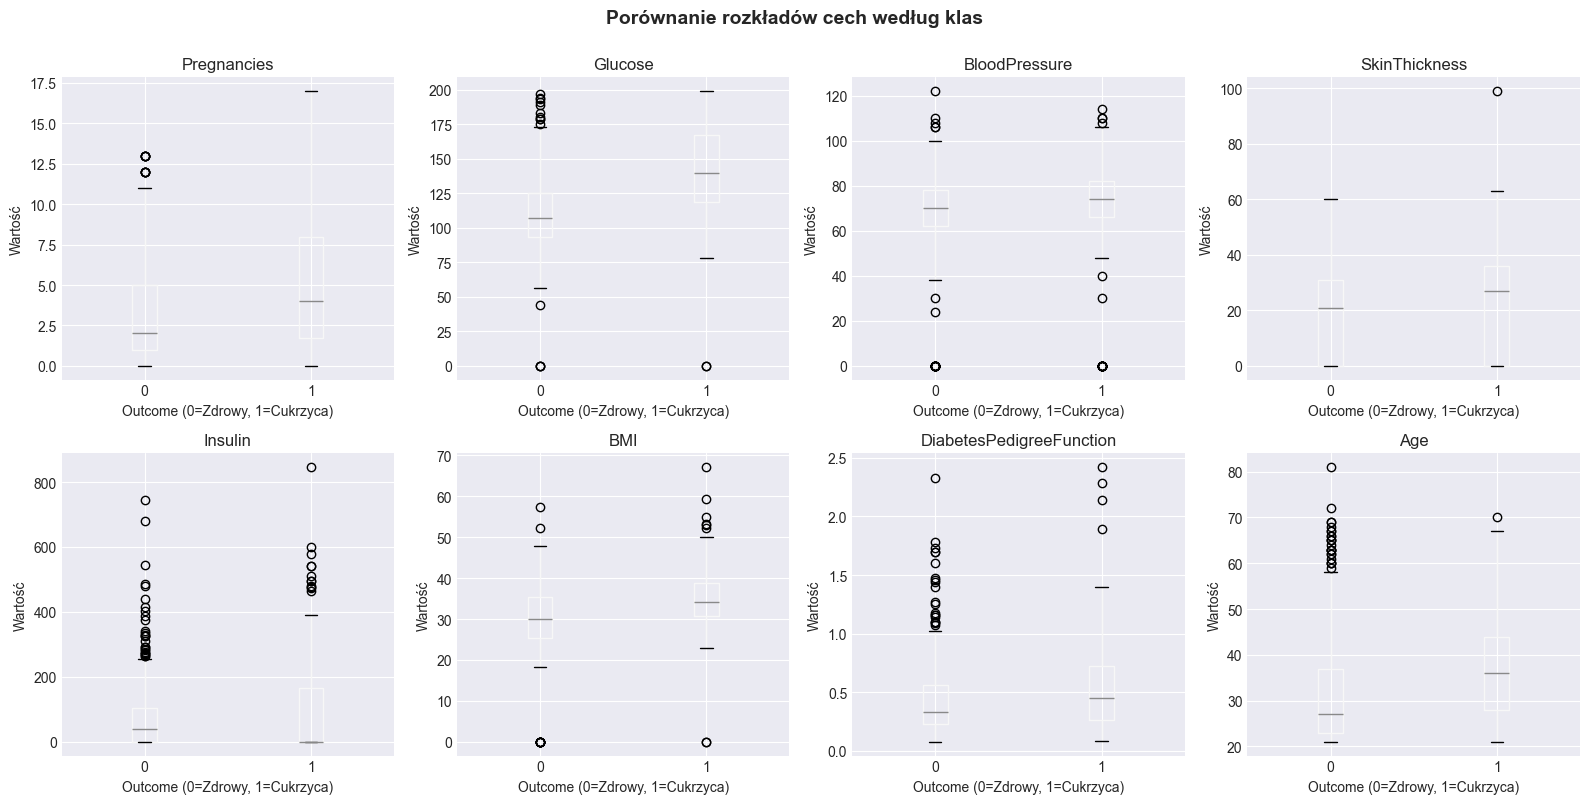

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

feature_cols = [col for col in df.columns if col != 'Outcome']

for idx, col in enumerate(feature_cols):
    df.boxplot(column=col, by='Outcome', ax=axes[idx])
    axes[idx].set_title(f'{col}')
    axes[idx].set_xlabel('Outcome (0=Zdrowy, 1=Cukrzyca)')
    axes[idx].set_ylabel('Wartość')

plt.suptitle('')
fig.suptitle('Porównanie rozkładów cech według klas', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3. Preprocessing danych

### 3.1 Imputacja braków danych

In [9]:
df_processed = df.copy()
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_cols:
    df_processed[col] = df_processed[col].replace(0, np.nan)

print("Braki danych po konwersji:")
missing = df_processed.isnull().sum()
missing_pct = 100 * missing / len(df_processed)
missing_df = pd.DataFrame({'Braki': missing, 'Procent': missing_pct})
print(missing_df[missing_df['Braki'] > 0])

Braki danych po konwersji:
               Braki    Procent
Glucose            5   0.651042
BloodPressure     35   4.557292
SkinThickness    227  29.557292
Insulin          374  48.697917
BMI               11   1.432292


In [10]:
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")
print(f"\nRozkład klas w y:\n{y.value_counts()}")

Kształt X: (768, 8)
Kształt y: (768,)

Rozkład klas w y:
Outcome
0    500
1    268
Name: count, dtype: int64


### 3.2 Podział na zbiór treningowy i testowy

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Zbiór treningowy: {X_train.shape}")
print(f"Zbiór testowy: {X_test.shape}")
print(f"\nRozkład klas w zbiorze treningowym:\n{y_train.value_counts()}")
print(f"\nRozkład klas w zbiorze testowym:\n{y_test.value_counts()}")

Zbiór treningowy: (614, 8)
Zbiór testowy: (154, 8)

Rozkład klas w zbiorze treningowym:
Outcome
0    400
1    214
Name: count, dtype: int64

Rozkład klas w zbiorze testowym:
Outcome
0    100
1     54
Name: count, dtype: int64


## 4. Porównanie metod uczenia maszynowego

### 4.1 Konfiguracja pipeline

Każdy pipeline obejmuje:
1. Imputacja - KNNImputer dla wartości brakujących
2. Skalowanie - StandardScaler dla normalizacji cech
3. Balansowanie - SMOTE dla wyrównania klas
4. Klasyfikator - jeden z czterech modeli

In [12]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        solver='lbfgs'
    ),
    'k-NN': KNeighborsClassifier(
        n_neighbors=5,
        metric='euclidean'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42,
        probability=True
    )
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = ImbPipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

print(f"Modele: {list(pipelines.keys())}")

Modele: ['Logistic Regression', 'k-NN', 'Random Forest', 'SVM (RBF)']


### 4.2 Trening i walidacja krzyżowa

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Trening modeli z walidacją krzyżową")

for name, pipeline in pipelines.items():
    print(f"\nTrening: {name}")
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_results[name] = cv_scores
    
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    pipeline.fit(X_train, y_train)

Trening modeli z walidacją krzyżową

Trening: Logistic Regression
CV Accuracy: 0.7801 (+/- 0.0141)

Trening: k-NN
CV Accuracy: 0.7132 (+/- 0.0446)

Trening: Random Forest
CV Accuracy: 0.7524 (+/- 0.0294)

Trening: SVM (RBF)
CV Accuracy: 0.7557 (+/- 0.0276)


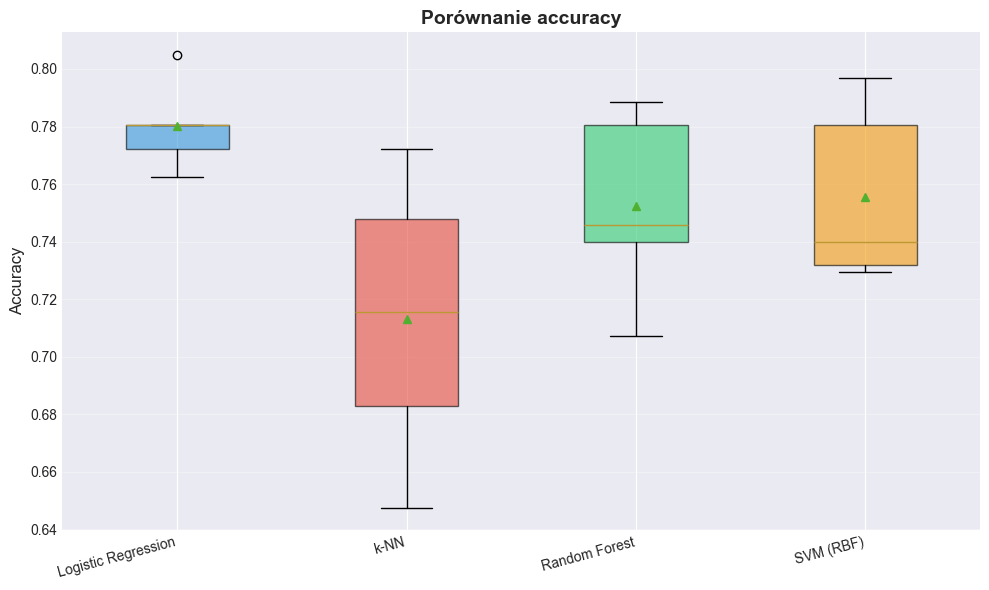

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

positions = np.arange(len(cv_results))
bp = ax.boxplot([scores for scores in cv_results.values()], 
                 labels=cv_results.keys(),
                 patch_artist=True,
                 showmeans=True)

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Porównanie accuracy', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

### 4.3 Ewaluacja na zbiorze testowym

In [15]:
results = []

print("Ewaluacja modeli na zbiorze testowym:")

for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'MCC': mcc
    })
    
    print(f"\n{name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    print(f"MCC:       {mcc:.4f}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\nRanking modeli (F1-Score):\n")
print(results_df.to_string(index=False))

Ewaluacja modeli na zbiorze testowym:

Logistic Regression:
Accuracy:  0.7208
Precision: 0.5932
Recall:    0.6481
F1-Score:  0.6195
ROC-AUC:   0.8081
PR-AUC:    0.6554
MCC:       0.4006

k-NN:
Accuracy:  0.7143
Precision: 0.5735
Recall:    0.7222
F1-Score:  0.6393
ROC-AUC:   0.7744
PR-AUC:    0.6011
MCC:       0.4153

Random Forest:
Accuracy:  0.6948
Precision: 0.5556
Recall:    0.6481
F1-Score:  0.5983
ROC-AUC:   0.8093
PR-AUC:    0.6820
MCC:       0.3573

SVM (RBF):
Accuracy:  0.7273
Precision: 0.6000
Recall:    0.6667
F1-Score:  0.6316
ROC-AUC:   0.8089
PR-AUC:    0.6601
MCC:       0.4175

Ranking modeli (F1-Score):

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC      MCC
               k-NN  0.714286   0.573529 0.722222  0.639344 0.774444 0.601089 0.415337
          SVM (RBF)  0.727273   0.600000 0.666667  0.631579 0.808889 0.660131 0.417490
Logistic Regression  0.720779   0.593220 0.648148  0.619469 0.808148 0.655435 0.400615
      Random Forest  0.6

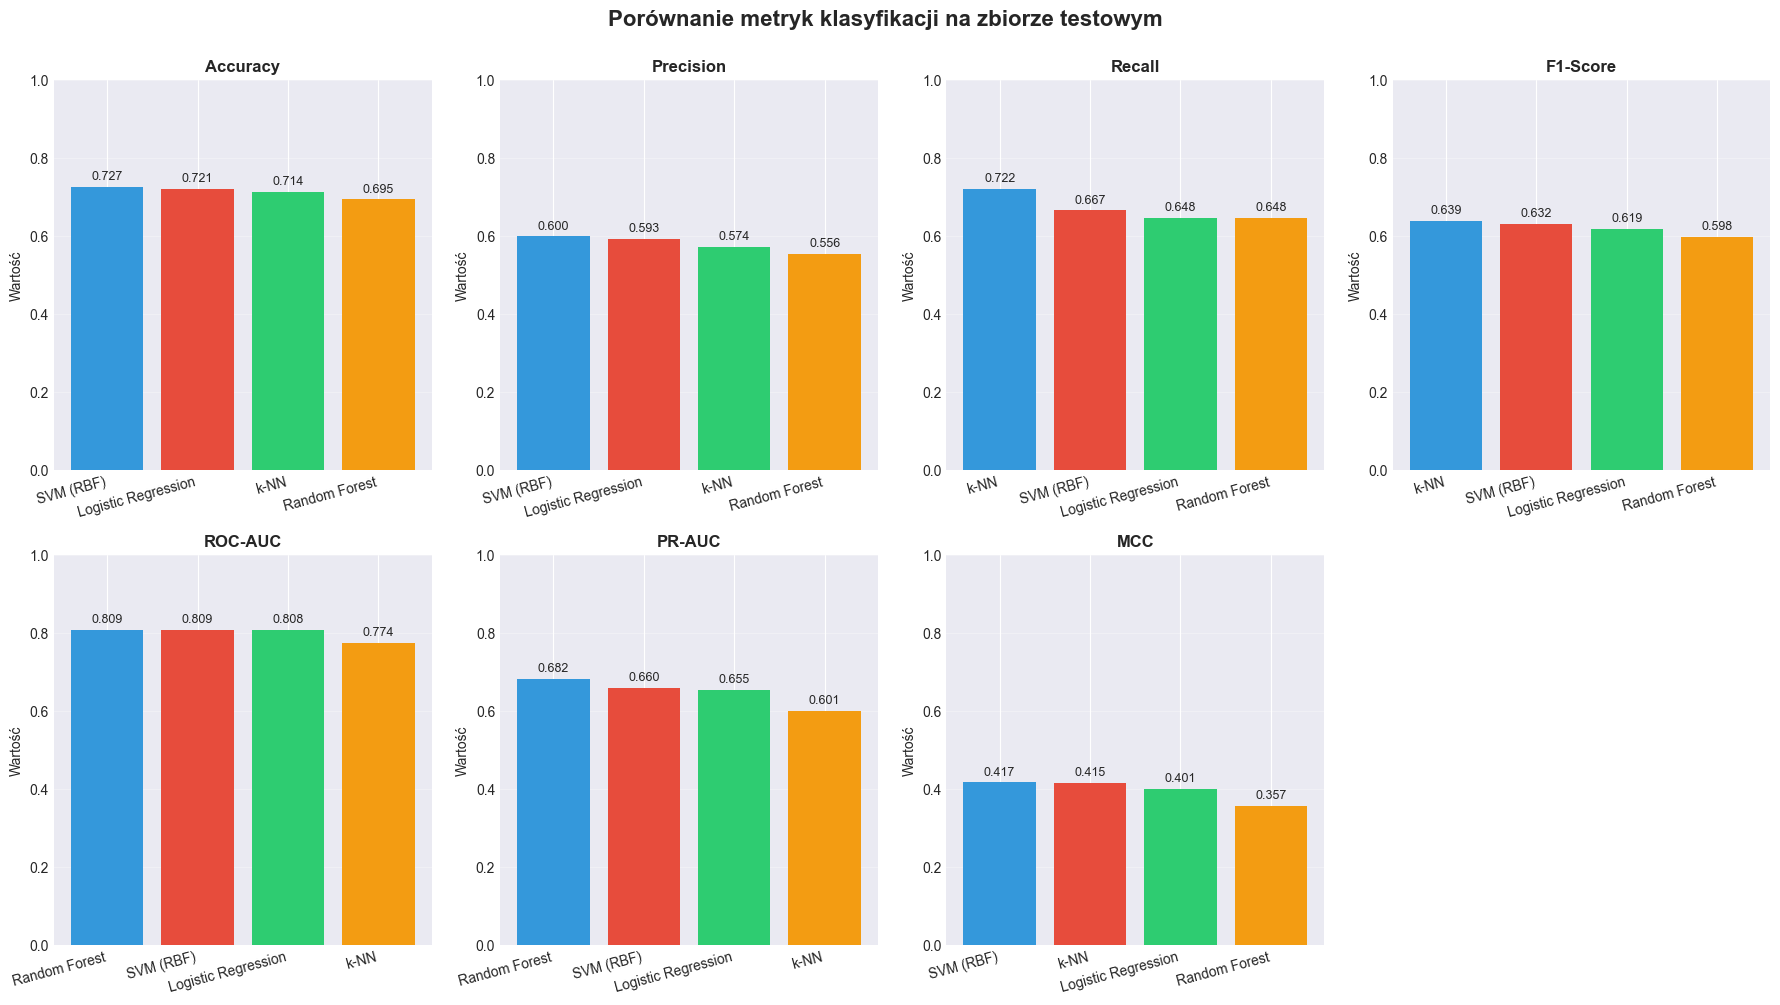

In [16]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC', 'MCC']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    data = results_df.sort_values(metric, ascending=False)
    bars = ax.bar(data['Model'], data[metric], color=colors)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Wartość')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

fig.delaxes(axes[-1])

fig.suptitle('Porównanie metryk klasyfikacji na zbiorze testowym', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4.4 Macierze pomyłek

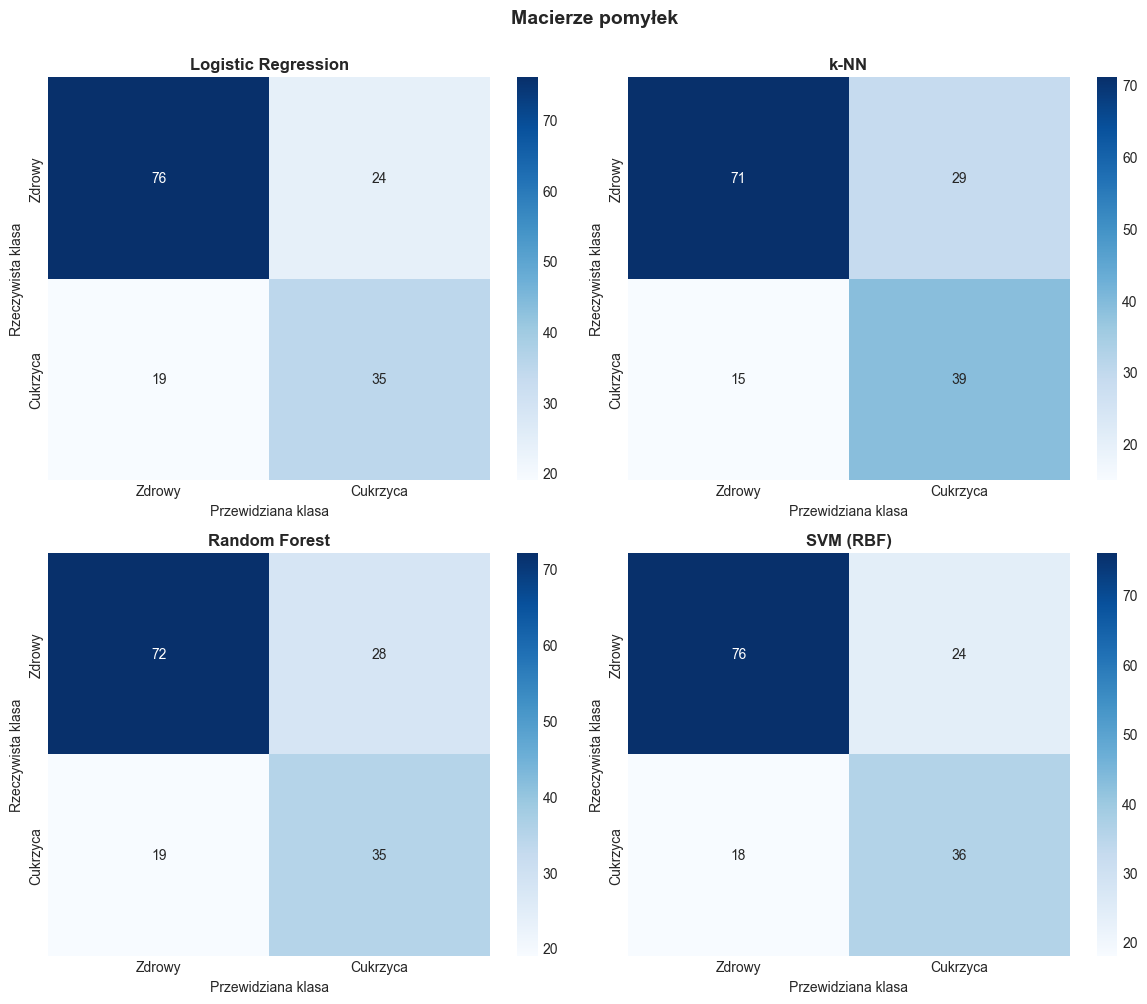

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, pipeline) in enumerate(pipelines.items()):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Zdrowy', 'Cukrzyca'],
                yticklabels=['Zdrowy', 'Cukrzyca'])
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Rzeczywista klasa')
    axes[idx].set_xlabel('Przewidziana klasa')

fig.suptitle('Macierze pomyłek', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4.5 Krzywe ROC

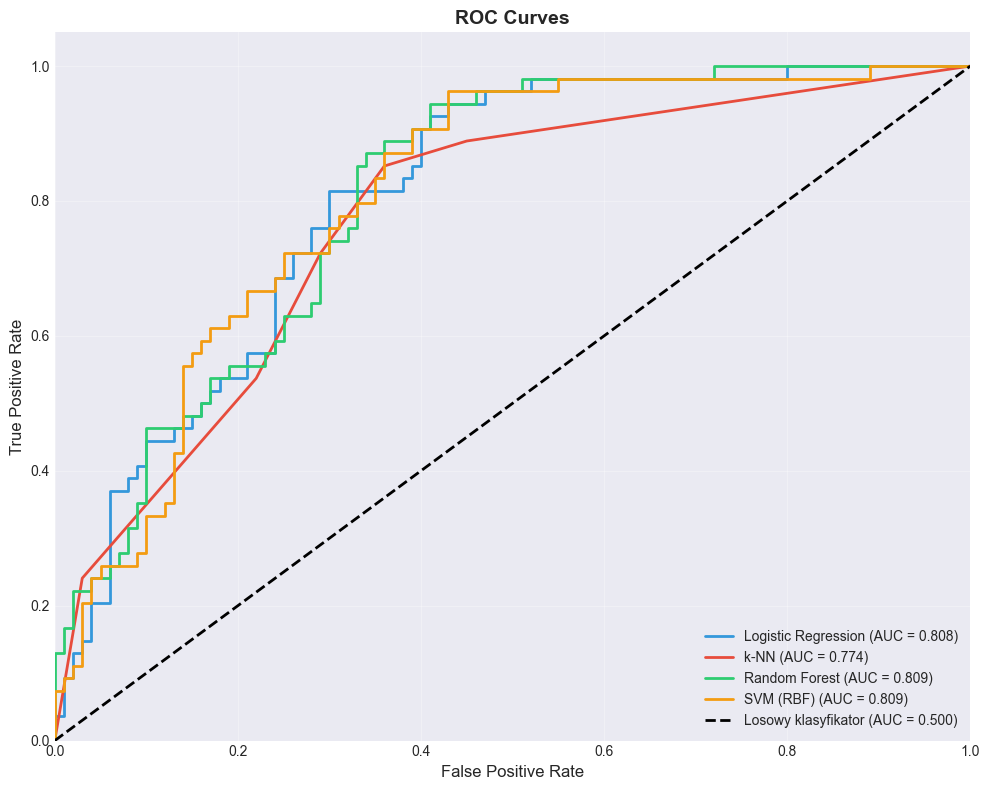

In [18]:
plt.figure(figsize=(10, 8))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (name, pipeline) in enumerate(pipelines.items()):
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Losowy klasyfikator (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.6 Krzywe Precision-Recall

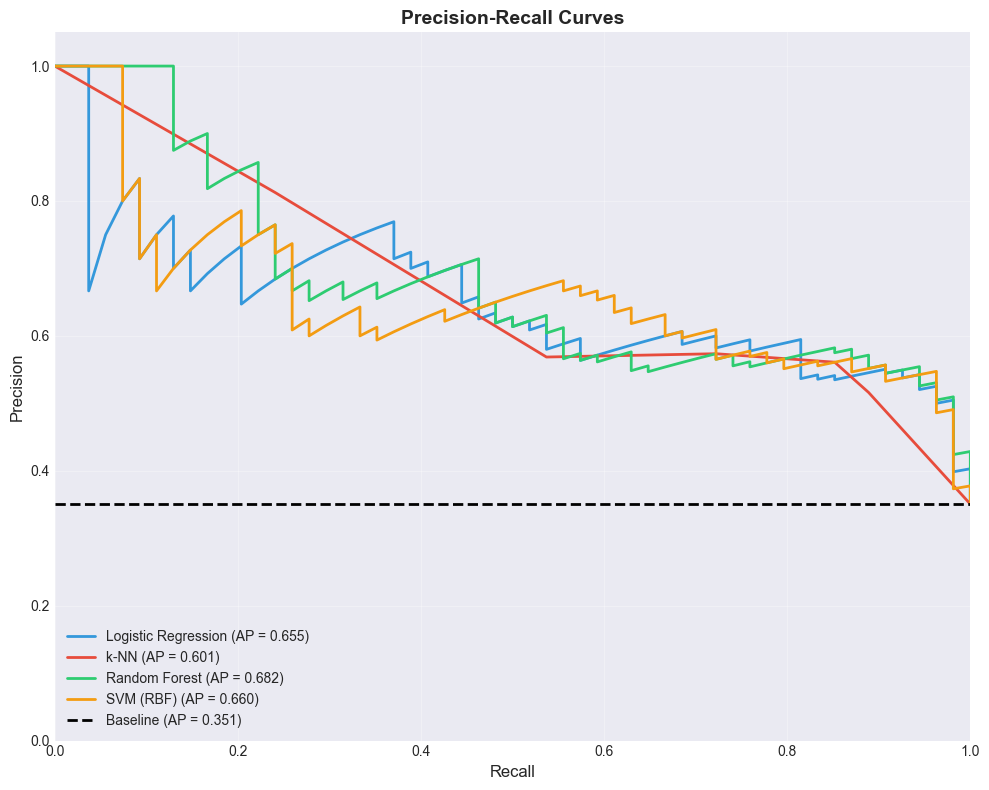

In [19]:
plt.figure(figsize=(10, 8))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

baseline = y_test.sum() / len(y_test)

for idx, (name, pipeline) in enumerate(pipelines.items()):
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2,
             label=f'{name} (AP = {pr_auc:.3f})')

plt.axhline(y=baseline, color='k', linestyle='--', lw=2, 
            label=f'Baseline (AP = {baseline:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.7 Krzywa DET

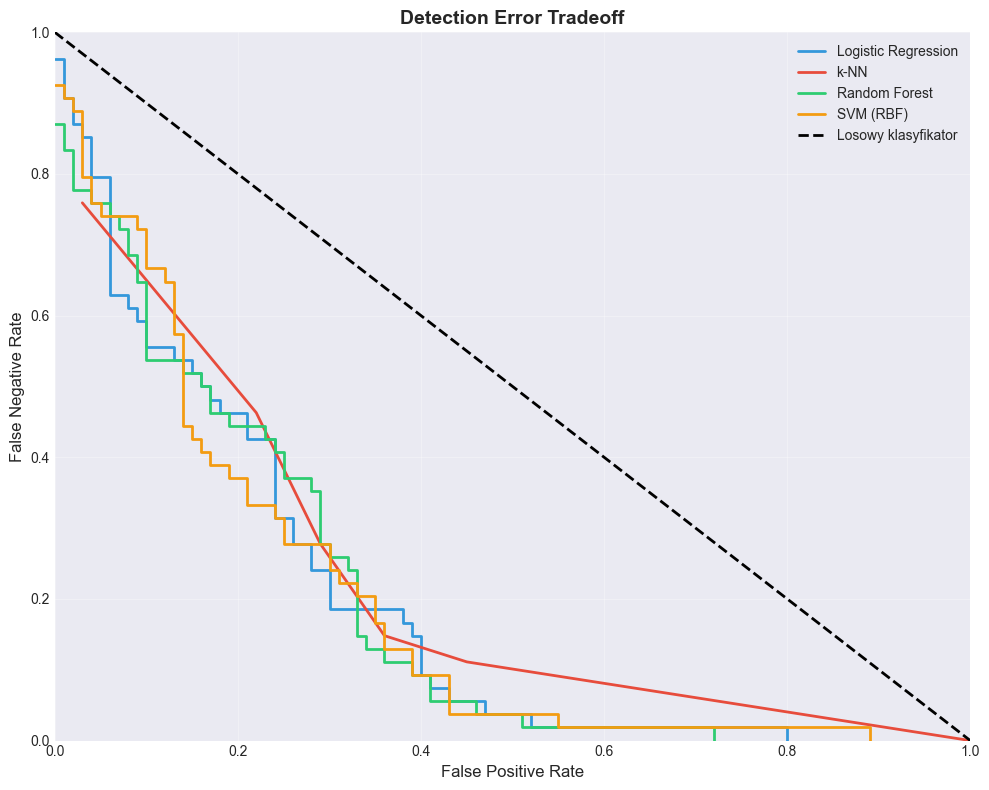

In [20]:
from sklearn.metrics import det_curve

plt.figure(figsize=(10, 8))

for idx, (name, pipeline) in enumerate(pipelines.items()):
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr_det, fnr_det, _ = det_curve(y_test, y_pred_proba)
    
    plt.plot(fpr_det, fnr_det, color=colors[idx], lw=2, label=name)

plt.plot([0, 1], [1, 0], 'k--', lw=2, label='Losowy klasyfikator')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('False Negative Rate', fontsize=12)
plt.title('Detection Error Tradeoff', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Wybór najlepszego modelu i zapis

In [21]:
best_model_name = results_df.iloc[0]['Model']
best_pipeline = pipelines[best_model_name]

print(results_df.iloc[0].to_string())

y_pred_best = best_pipeline.predict(X_test)
print(f"\nClassification Report ({best_model_name}):\n")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Zdrowy (0)', 'Cukrzyca (1)']))

Model            k-NN
Accuracy     0.714286
Precision    0.573529
Recall       0.722222
F1-Score     0.639344
ROC-AUC      0.774444
PR-AUC       0.601089
MCC          0.415337

Classification Report (k-NN):

              precision    recall  f1-score   support

  Zdrowy (0)       0.83      0.71      0.76       100
Cukrzyca (1)       0.57      0.72      0.64        54

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.72       154



In [22]:
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

model_path = models_dir / 'pima_pipeline.pkl'
joblib.dump(best_pipeline, model_path)

print(f"Model zapisany: {model_path}")

Model zapisany: ..\models\pima_pipeline.pkl


### 5.1 Obliczenie zakresów referencyjnych z rzeczywistych danych

In [23]:
healthy_data = df[df['Outcome'] == 0]

print("Zakresy referencyjne z osób zdrowych (n={}):\n".format(len(healthy_data)))

features_to_analyze = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

reference_ranges = {}

for feature in features_to_analyze:
    if feature in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        data = healthy_data[healthy_data[feature] > 0][feature]
    else:
        data = healthy_data[feature]
    
    p10 = data.quantile(0.10)
    p50 = data.quantile(0.50)
    p90 = data.quantile(0.90)
    mean_val = data.mean()
    
    reference_ranges[feature] = {
        'min': round(float(p10), 2),
        'optimal': round(float(p50), 2),
        'max': round(float(p90), 2),
        'mean': round(float(mean_val), 2),
        'label': feature
    }
    
    print(f"{feature:25s}: min={p10:6.2f}  optimal={p50:6.2f}  max={p90:6.2f}  mean={mean_val:6.2f}")

import json

reference_path = models_dir / 'reference_ranges.json'
with open(reference_path, 'w') as f:
    json.dump(reference_ranges, f, indent=2)

print(f"\nZakresy referencyjne zapisane: {reference_path}")

Zakresy referencyjne z osób zdrowych (n=500):

Pregnancies              : min=  0.00  optimal=  2.00  max=  8.00  mean=  3.30
Glucose                  : min= 83.00  optimal=107.00  max=143.40  mean=110.64
BloodPressure            : min= 56.00  optimal= 70.00  max= 86.00  mean= 70.88
SkinThickness            : min= 15.00  optimal= 27.00  max= 41.00  mean= 27.24
Insulin                  : min= 48.00  optimal=102.50  max=250.50  mean=130.29
BMI                      : min= 23.00  optimal= 30.10  max= 39.40  mean= 30.86
DiabetesPedigreeFunction : min=  0.16  optimal=  0.34  max=  0.80  mean=  0.43
Age                      : min= 21.00  optimal= 27.00  max= 48.00  mean= 31.19

Zakresy referencyjne zapisane: ..\models\reference_ranges.json


## 6. Wnioski i analiza wyników

Na podstawie przeprowadzonej analizy porównawczej czterech algorytmów klasyfikacji k-NN, SVM, Logistic Regression i Random Forest wybrany został model k-NN ze względu na najwyższy wynik F1-Score 0.6393 oraz charakterystykę jego wydajności. Model osiągnął recall na poziomie 72.2%, co jest szczególnie istotne w kontekście medycznym, gdzie pominięcie pacjenta z cukrzycą niesie znacznie większe ryzyko niż fałszywy alarm. Spośród analizowanych cech to poziom glukozy okazała się zdecydowanie najważniejszym predyktorem z korelacją 0.467 do zmiennej docelowej. Przeprowadzona analiza ujawniła jednak kilka ograniczeń wpływających na wyniki modelu:
- niezbalansowanie klas
- brakujące dane szczególnie w kolumnie Insulin
- stosunkowo mały zbiór danych treningowych

Aby uzyskać lepsze wyniki i bardziej niezawodne przewidywania w praktyce klinicznej, niezbędne jest rozszerzenie zbioru danych o nowe próbki pacjentów oraz uzupełnienie brakujących informacji. Rozszerzony zbiór umożliwi lepszą generalizację modelu, więcej próbek dla klasy mniejszościowej oraz weryfikację stabilności algorytmu na bardziej reprezentatywnych danych demograficznych.

Model k-NN został zapisany do pliku `models/pima_pipeline.pkl` wraz z ustawioną konfiguracją imputacji brakujących danych KNNImputer, standaryzacji cech StandardScaler oraz balansowania klas SMOTE.